In [4]:
# loading all the dependencies
import pandas as pd

from scipy.optimize import fsolve
from openpyxl import load_workbook

import numpy as np
import uncertainties as uc

pd.options.display.float_format ='{:,.3f}'.format
import matplotlib.pyplot as plt
%matplotlib inline  
from IPython.display import Image
from IPython.core.display import HTML 

from scipy import integrate
import scipy.stats as stats
from uncertainties import ufloat
from uncertainties import unumpy
from sklearn.linear_model import LinearRegression


# Myocytes - Skeltal Muscle cells

Muscle cells are the biggest cells in the body

## Myocytes number
In previous research [Sender et al., 2016](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1002533) we used estimates given at [Bianconi et al., 2013](https://www.ncbi.nlm.nih.gov/pubmed/23829164). Their estimate originate in Howell WH, Fulton JF. 1949. A textbook of physiology which have no primary source for that claim. Here we check the previous estimate by comparison with relevant new data from 3 sources:  [Holzbaur et al., 2007](https://www.ncbi.nlm.nih.gov/pubmed/17241636) , [Lube et al., 2016](https://www.ncbi.nlm.nih.gov/pubmed/26251021) and [Zheng et al., 2013](https://www.ncbi.nlm.nih.gov/pubmed/23351366) 

total number of cells 2.9e+07


C:\Users\ronse\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


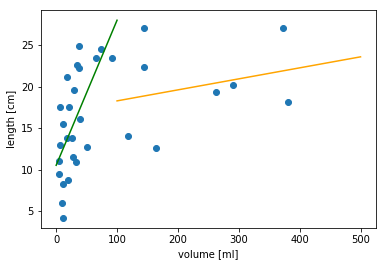

In [5]:
volume_data = pd.read_excel('Myocytes_data.xlsx','volume_data',index_col=0)
volume_data.head()



# 
plt.scatter(volume_data.loc[:,'volume (ml)'],volume_data.loc[:,'length (cm)'])
ax = plt.gca()

plt.ylabel('length [cm]')
plt.xlabel('volume [ml]')



###regression to fill in the length for the data from 2 sources that don't have length measurements
y = volume_data.loc[:,'length (cm)']
x = volume_data.loc[:,'volume (ml)']

x = x[np.argwhere(~np.isnan(y))]
y = y[np.argwhere(~np.isnan(y))]

cutoff = 100

x_low = x[x<=cutoff]
y_low = y[x<=cutoff]
x_low = x_low.reshape(-1,1)
#use of rehsape so x would be in the right shape for the regression model fit

x_hi = x[x>cutoff]
y_hi = y[x>cutoff]
x_hi = x_hi.reshape(-1,1)
#use of rehsape so x would be in the right shape for the regression model fit

#creating two models, one for the data above the threshold and one for below
model_low = LinearRegression().fit(x_low, y_low)
r_sq_low = model_low.score(x_low, y_low)

model_hi = LinearRegression().fit(x_hi, y_hi)
r_sq_hi = model_hi.score(x_hi, y_hi)


#print('coefficient of determination low: {:0.2f}'.format(r_sq_low))
#print('coefficient of determination hi:{:0.2f}'.format(r_sq_hi))

xsapce_low = np.linspace(0,cutoff).reshape(-1,1)
xsapce_hi = np.linspace(cutoff,500).reshape(-1,1)

y_pred_low = model_low.predict(xsapce_low)
y_pred_hi = model_hi.predict(xsapce_hi)

plt.plot(xsapce_low,y_pred_low,'g')
plt.plot(xsapce_hi,y_pred_hi,'orange')


#####################
#defining columns for the values given by the regression model. the right values will be chosen, given the volume in relation to the cutoff
volume_data.loc[:,'hi_len_est']= model_hi.predict(volume_data.loc[:,'volume (ml)'].values.reshape((-1,1)))
volume_data.loc[:,'low_len_est']= model_low.predict(volume_data.loc[:,'volume (ml)'].values.reshape((-1,1)))


#some of the muscles are bigger than waht we have data on. we use assumption regarding their length, instead of regression
hi_cutoff = volume_data.loc[:,'length (cm)'].where(np.isnan(volume_data.loc[:,'length (cm)']),volume_data.loc[:,'volume (ml)']).max(axis=0)
#print(hi_cutoff)

hi_len_asmp = 30 #cm , assumption for very massive muscles

#for i in volume_data.index:
#    if ~np.isnan(volume_data.loc[i,'length (cm)']):
#        volume_data.loc[i,'est_len'] = volume_data.loc[i,'length (cm)']
#    elif volume_data.loc[i,'volume (ml)'] <= cutoff:
#        volume_data.loc[i,'est_len'] = volume_data.loc[i,'low_len_est']
#    elif volume_data.loc[i,'volume (ml)'] > hi_cutoff:
#         volume_data.loc[i,'est_len'] = hi_len_asmp
#    else:
#         volume_data.loc[i,'est_len'] = volume_data.loc[i,'hi_len_est']

#using DataFrame where function to chose what length estimate to use
#it seems that the condition in the where method is counterintuitive (reverased)
volume_data.loc[: ,'est_len']= volume_data.loc[:,'low_len_est']
volume_data.loc[: ,'est_len']= volume_data.loc[: ,'est_len'].where(volume_data.loc[:,'volume (ml)']<=cutoff,volume_data.loc[:,'hi_len_est'])
volume_data.loc[: ,'est_len']= volume_data.loc[: ,'est_len'].where(volume_data.loc[:,'volume (ml)']<=hi_cutoff,hi_len_asmp )
volume_data.loc[: ,'est_len']= volume_data.loc[: ,'est_len'].where(np.isnan(volume_data.loc[:,'length (cm)']),volume_data.loc[:,'length (cm)'])

#print(volume_data[['est_len','hi_len_est','low_len_est']])


###########
#using length estimates to the number of cells. 
#based on assumpotion regarding the daimeter of the cells, and the fact that the length of individual cell is the same as 
#the length od the entire muscle

volume_data.loc[: ,'est_cross_area'] = volume_data.loc[:,'volume (ml)']/volume_data.loc[: ,'est_len']
volume_data.loc[: ,'est_diameter'] = 2*np.sqrt(volume_data.loc[: ,'est_cross_area']/np.pi)

#number of cells is given by dividing the cross area by the cross area of single cell
#we assume cross area based on the literature, assuming cell in large muscle has bigger diameter

diameter_large = 60*10**-4 #60 microns moving to cm
diameter_small = 30*10**-4 #30 microns moving to cm


volume_data.loc[: ,'single_diameter']=diameter_small
volume_data.loc[: ,'single_diameter']= volume_data.loc[: ,'single_diameter'].where(volume_data.loc[:,'volume (ml)']<=cutoff,diameter_large)


volume_data.loc[: ,'single_area'] = np.pi*(volume_data.loc[: ,'single_diameter']/2)**2

volume_data.loc[: ,'number of cells'] = volume_data.loc[: ,'est_cross_area']/volume_data.loc[: ,'single_area']

#print(volume_data[['est_cross_area','est_diameter','single_area']])
#print(volume_data.loc[: ,'number of cells'].sum)

print('total number of cells {:0.1e}'.format(volume_data.loc[: ,'number of cells'].sum(axis=0)))




We now have an estimate for the number of cell in 80 single muscle(from 1 side of the body), assuming that their pair has the same number of cells, we need to estimate the number of cells in the other 480/640 muscles.

We can use the overall mass in the 80 muscles to estimate what mass there is need to come by.We need to take in acount that the patients' height in these research was higher than our reference man, and to compensate for it. We take the same 40% mass in skeletal muscle, and take a reference mass of 80 kg instead of 70


In [6]:
##specific gravity of skeletal muscle tissue is 1.04 according to Snyder et al., 1975
sp_g = 1.04

#taking in acount the muscles and their pairs
acounted_mass =2* volume_data.loc[:,'volume (ml)'].sum(axis=0)*sp_g/1000 #moving acounted mass to kg units
print('acounted mass {:0.1f} kg'.format(acounted_mass))

higher_mass = 75
SM_prop = 0.4


mass_left = higher_mass*SM_prop-acounted_mass
print('need to acounted for {:0.1f} kg more'.format(mass_left ))


##############
#we get two estimates (low and hi) for the number of cells, using assumptions regarding their average length
muscles_left = 480


muscle_avg_mass = mass_left//1000 #in grams
muscle_avg_volume = mass_left/sp_g # in ml

hi_len = 3 #cm, given in "Blue Histology - Muscle"
low_len = 0.5 #cm, taken as lower bound


#deriving the number of cells by taking the cross section area and dividing by single cells area
#and multiplying by the number of cells
hi_num_cells = muscles_left*(muscle_avg_volume/low_len)/ (np.pi*(diameter_small/2)**2)
low_num_cells = muscles_left*(muscle_avg_volume/hi_len)/ (np.pi*(diameter_small/2)**2)

remain_cells =stats.gmean([hi_num_cells,low_num_cells])
remain_cells = ufloat(remain_cells,np.sqrt(hi_num_cells/remain_cells)*remain_cells)

#print('hi num {:0.1e}'.format(hi_num_cells))
#print('low num {:0.1e}'.format(low_num_cells))

print('remaining cells: {:0.1eP}'.format(remain_cells))

#combining the number for the known 80 muscles and the remained cells
myocyte_num = remain_cells + 2*volume_data.loc[: ,'number of cells'].sum(axis=0)
print('total muscle cells: {:0.1eP} '.format(myocyte_num))

 

acounted mass 26.6 kg
need to acounted for 3.4 kg more
remaining cells: (1.8±2.9)×10⁸
total muscle cells: (2.4±2.9)×10⁸ 


The estimate we got for the number of muscle cells agrees with the previous estimate.

## Myocytes age

The average cells age of skeletal muscle tissue was estimated using carbon 14, by [Spalding et al., 2005](https://www.ncbi.nlm.nih.gov/pubmed/16009139) for two patients at age 37-38 years. We use their estimate, combined with data regarding the prelevance of different cells in the skeletal muscle tissue to get an average age estimate for the myocytes alone.
We use data regarding the population of satellite cells (accompanied myo-stem cells in the skeletal muscle tissue) from [Dumont et al., 2015](https://www.ncbi.nlm.nih.gov/pubmed/26140708) and endothelial (blood vessels) cells from [Zheng et al., 2007](https://www.ncbi.nlm.nih.gov/pubmed/17767154).

We emphasize that myocytes are multinucleated cells, and so we are interested in the prelevance of cells in terms of nuclei, as that what affect the average age estimate.
Using the nuceleardomain (volume per nucleus) and cell volume (derived from total cellular mass, according to potasium concentraion, based on a furmola from [Wang et al., 2004](https://www.ncbi.nlm.nih.gov/pubmed/14532167)) we get also the number of nuclei in muscle cells and the number of satellite cells (they have 1 nucleus)


In [15]:
cell_population = pd.read_excel('Myocytes_data.xlsx','cells_population',index_col=0,usecols = range(0,4))
cell_population.loc[:,'% of total'] = cell_population.loc[:,'% of myonuclei']/ cell_population.loc[:,'% of myonuclei'].sum(axis=0) 
cell_population.loc[:,'delta % of total'] = cell_population.loc[:,'% delta']*cell_population.loc[:,'% of total']/cell_population.loc[:,'% of myonuclei']


total_cellular_mass = ufloat(19800,2500) #g based on Snyder et al.,1975 and Wang et al., 2004
#assuming the proportion of myocytes is as described from nuclei population data  

myocyte_proportion = ufloat(cell_population.loc['myocytes','% of total'],cell_population.loc['myocytes','delta % of total'])
average_myocte_volume =(myocyte_proportion*total_cellular_mass/myocyte_num/sp_g)*10**12  #in fl units
#print('{:0.1eP} fl'.format(average_myocte_volume))



#Dumont gives values of 2-5*10^4 micron^3
nuclear_domain = ufloat(3*10**4,10**4)  # mu^3/nucleus
average_myocyte_nuclei = average_myocte_volume/nuclear_domain #per cells

toatal_myocytes_nuclei = (myocyte_proportion*total_cellular_mass/sp_g)*10**12/nuclear_domain

#print('{:0.1eP} '.format(average_myocyte_nuclei))
#print('{:0.1eP} '.format(toatal_myocytes_nuclei))

#using the uncertainty library to estimates the combined errors
cell_prop = unumpy.uarray(cell_population.loc[:,'% of total'].values, cell_population.loc[:,'delta % of total'].values)
cell_num = cell_prop*toatal_myocytes_nuclei/cell_prop[0]

cell_population.loc[:,'nuclei num'] = unumpy.nominal_values(cell_num)
cell_population.loc[:,'delta nuclei num'] = unumpy.std_devs(cell_num)


print('numebr of satellite cells: {:0.1eP} '.format(cell_num[1]))

#for the estimates of in the different types of cells we need to take in acount their mass proportion that consider their sizes: 
cell_population['ref cell volum'] = nuclear_domain  #assumin satellite cells have similar volume as the nuclear domain of myocytes 
cell_population.loc['endithelial cells','ref cell volum'] = 1200 #volume of endothelial cells in mu^3

cell_population['mass proportion'] =cell_population['ref cell volum']*cell_population['% of total']/np.dot(cell_population['ref cell volum'],cell_population['% of total']) 
myocyte_mass_proportion = cell_population.loc['myocytes','mass proportion']
##############################
#using the average age estimated for endothelial cells in Bergman 2015, 
#we use different assumption regarding satellite cells age to estimate the average age of myocytes

total_average_age = 15.1 #years, according to Spalding et al., 2005

#estimate regarding the age of satellite cells
sat_age_hi = 15
sat_age_low= 3

#computed age of myocytes by the opposite of weighted average
myo_age_low = (total_average_age -np.dot(cell_prop[1:3], [sat_age_low,cell_population.loc['endithelial cells','average age']]))/cell_prop[0] 
myo_age_hi = (total_average_age -np.dot(cell_prop[1:3], [sat_age_hi,cell_population.loc['endithelial cells','average age']]))/cell_prop[0] 

#as the age of satellite cells has a minor effect on the estimate of myocytes age we use the average of the 2 estimate
myoctes_age = (myo_age_low+myo_age_hi)/2

print('myocyte average age {:0.1fP} years '.format(myoctes_age))


numebr of satellite cells: (3.5±2.6)×10¹⁰ 
myocyte average age 16.4±0.8 years 


### Myocytes mean mass
We can use the number of Myocytes together with an estimate for the total cellualr mass in skeletal muscles to obtain the average mass of a myocyte.

In [17]:

myocyte_mean_mass = myocyte_mass_proportion *total_cellular_mass/myocyte_num*10**12
print('myocyte mean mass {:0.1eP} pg '.format(myocyte_mean_mass))

total_myocytes_mass =myocyte_mass_proportion *total_cellular_mass
print('total myocytes mass {:0.2eP} grams '.format(total_myocytes_mass))



myocyte mean mass (7.7±9.2)×10⁷ pg 
total myocytes mass (1.85±0.23)×10⁴ grams 


## Myocytes turnover rates
We use the data regarding the average age of myocytes ( [Spalding et al., 2005](https://www.ncbi.nlm.nih.gov/pubmed/16009139) ) at the given age to estimate the lifespan and turnover rates of these cells. Given the available single data point, we use the simplest model to derive the lifespan from the average age, as described in [Bernard et al.,2010](https://www.sciencedirect.com/science/article/pii/S0168583X09012051).


### Mathematical model of average age
We use the simplels model: constant production rate $\beta$ (units: cells/year), and constant death rate $\gamma$ (units: 1/year) 
$$\frac{dN}{dt} =\beta-\gamma N.$$
$$ N(t) = \frac{\beta}{\gamma}(1-e^{-\gamma t})$$
the survival function is given by: $SF(t) =e^{-\gamma t}  $

the distribution of ages of cells, is shaped like the survival function, only that its integral is equal to $N(t)$
$ n(t,a) = \beta e^{-\gamma a}$ , where $a$ is the age of cells, and $t$ the age of the person

We can get an experssion for the average age of the cells:
$$<a> =\frac{\int a n(t,a)da}{N(t)} = \frac{\int \beta a e^{-\gamma a}da}{\frac{\beta}{\gamma}(1-e^{-\gamma t})}= \frac{\gamma \int a e^{-\gamma a}da}{(1-e^{-\gamma t})} = \frac {1-e^{-\gamma t}(1+\gamma t)}{\gamma (1-e^{-\gamma t})} = \frac{1}{\gamma} + t -\frac{t}{1-e^{-\gamma t}}$$

Given data regarding $t$ and $<a>$ we can derive $\gamma$ and the lifespan from it

We need to mention that this in this model their is a change in the total number of cells, but for mature adult that change is very little.


### Lifespan derivation from age 
We now use the expression we got to derive the death rate and lifespan of myocytes.
We solve the equation using numeric method


In [18]:
t=37.5 #age of patients
a=myoctes_age.nominal_value

#defining the equation as a function that can be numerily solved
equation = lambda g,a : 1/g - t/(1 - np.exp(-g*t)) + t-a
#defining initial geuss. we now that gamma is <1 
gamma_initial_guess = 0.5

gamma = fsolve(equation, gamma_initial_guess,args=a)

####
#we want to get an error estimate by using the errors estimate of a.
##

a_hi = a + myoctes_age.std_dev
a_low = a - myoctes_age.std_dev


gamma_low = fsolve(equation, gamma_initial_guess,a_hi)
gamma_hi = fsolve(equation, gamma_initial_guess,a_low)

#and now we store the value in ufloat
gamma = ufloat(gamma, (gamma_hi-gamma_low)/2)

####
#the lifespan is given by 1/death rate and the cellular turnover rate ny N/lifespan

myocytes_lifespan = 1/gamma
myocytes_turnover =  myocyte_num/(myocytes_lifespan*365) #moving from years to days

myocytes_mass_turnover = myocytes_turnover*average_myocte_volume*sp_g/10**12

print('myocyte lifespan: {:0.1fP} years'.format(myocytes_lifespan))
print('cellular turnover rate {:0.1eP} cells per day'.format(myocytes_turnover))
print('cellular mass turnover rate {:0.1fP} grams per day'.format(myocytes_mass_turnover))


myocyte lifespan: 50.2±18.2 years
cellular turnover rate (1.3±1.6)×10⁴ cells per day
cellular mass turnover rate 0.9±0.4 grams per day


## Saving the results to excell
So it can be used for summary 

In [19]:
results =pd.DataFrame(index = range(4), columns=['Parameter','Value','Units','Uncertainty']) 
results.loc[0] = pd.Series({
                'Parameter': 'number',
                'Value': myocyte_num.nominal_value,
                'Units': 'Cells',
                'Uncertainty': myocyte_num.std_dev
                })

results.loc[1] = pd.Series({
                'Parameter': 'lifespan',
                'Value': 365*myocytes_lifespan.nominal_value, #from years to days
                'Units': 'days',
                'Uncertainty': 365*myocytes_lifespan.std_dev #from years to days
                })

results.loc[2] = pd.Series({
                'Parameter': 'cellular turnovr rate',
                'Value': myocytes_turnover.nominal_value,
                'Units': 'cells per day',
                'Uncertainty':myocytes_turnover.std_dev
                })

results.loc[3] = pd.Series({
                'Parameter': 'cell mass',
                'Value': myocyte_mean_mass.nominal_value,
                'Units': 'pg',
                'Uncertainty':myocyte_mean_mass.std_dev
                })

results.loc[4] = pd.Series({
                'Parameter': 'cellular mass turnovr rate',
                'Value':myocytes_mass_turnover.nominal_value,
                'Units': 'grams per day',
                'Uncertainty': myocytes_mass_turnover.std_dev
                })

results.loc[5] = pd.Series({
                'Parameter': 'total cellular mass',
                'Value':total_myocytes_mass.nominal_value,
                'Units': 'grams per day',
                'Uncertainty': total_myocytes_mass.std_dev
                })
   
%run Utility_Functions.ipynb
#results
file = 'Summary.xlsx'
book = load_workbook(file)
writer = pd.ExcelWriter(file, engine = 'openpyxl')
writer.book = book

writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
sheet=writer.book.active

results.to_excel(writer, sheet_name = 'Myocytes',index=False)
worksheet = writer.sheets['Myocytes']   
#     using the colors defined in the color sheet to color the tabs. Using the extraction of the data in the Utility_Functions.ipynb notebook
worksheet.sheet_properties.tabColor= colors_data.loc['Myocytes','hex'] 


writer.save()
